## Exploring Twitter Sentiments towards U.S. Airlines: A February 2015 Analysis
We delve into sentiment analysis using Twitter data that encapsulates the challenges encountered by prominent U.S. airlines. The dataset, compiled from tweets posted in February 2015, undertakes the task of classifying tweets into positive, negative, or neutral sentiments. Furthermore, contributors were engaged in the critical task of associating negative sentiments with specific reasons, such as issues like "late flight" or "rude service." This comprehensive analysis illuminates public opinions concerning six major U.S. airlines, offering valuable insights into customer experiences and airline performance.

​
<br>
​
For example, it contains whether the sentiment of the tweets in this set was positive, neutral, or negative for six US airlines:

​
The information of main attributes for this project as follows;
​
* **`alirline_sentiment`** : Sentiment classification.(positivie, neutral, and negative)
* **`negativereason`** : Reason selected for the negative opinion
* **`airline`** : Name of 6 US Airlines('Delta', 'United', 'Southwest', 'US Airways', 'Virgin America', 'American')
* **`text`** : Customer's opinion
​
<br>

<br>

<img src = "https://www.surveysensum.com/wp-content/uploads/2020/02/SENTIMENT-09-1.png">

<br>

## IMPORT LIBRARIES

In [1]:
# Standard Library Imports
import os
import re
import pickle
import joblib

# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

# Text Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
#Deep Learning Using TensorFlow and Keras"
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout, Conv1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

## Data Loading: Loading Data from "Tweets.csv"

In [2]:
data = pd.read_csv("Tweets.csv")

## Checking Dataset Dimensions.

In [3]:
print(data.shape)

(14640, 15)


## Data Preview: First 5 Rows of the Loaded Data

In [4]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## Dataset Information

This section provides an overview of the dataset, including details about its structure, columns, and data types.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

## Handling Missing Values: Context and Decisions
To get a better idea, lets calculate the percentage of nulls or NA values in each column

In [6]:
print("Percentage of Missing Values in DataFrame:")
missing_percentage = ((data.isnull() | data.isna()).sum() * 100 / data.index.size).round(2)
print(missing_percentage)


Percentage of Missing Values in DataFrame:
tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64


**tweet_coord , airline_sentiment_gold, negativereason_gold**  have more than 90% missing data. It will be better to delete these columns as they will not provide any constructive information.

Also we can delete the **tweet_id** column because here it will not be used.


In [7]:
columns_to_drop = ['tweet_id','tweet_coord', 'airline_sentiment_gold', 'negativereason_gold']
data.drop(columns=columns_to_drop, inplace=True)
data.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


**In our dataset, we encounter anther four columns with a substantial percentage of missing values:**

1. **user_timezone**
2. **tweet_location**
3. **negativereason_confidence**
4. **negativereason**

### user_timezone:

- This column plays a pivotal role in studying variations in user behavior across different time zones.
- Due to its potential impact on analysis, we opt to fill missing values.
- We will fill the gaps using the mode, the most common time zone, ensuring minimal disruption to time-related patterns.

### tweet_location:

- Analyzing user locations could provide valuable insights, making this column significant.
- To preserve the integrity of location-based analysis, we decide to fill missing values.
- A plausible strategy is using external sources or geolocation services to populate the gaps accurately.

### negativereason_confidence:

- The confidence level of negative reasons contributes to the depth of sentiment analysis.
- Recognizing its significance, we choose to address missing values.
- We plan to impute the gaps using the median value, maintaining the distribution of confidence levels.

### negativereason:

- Deleting rows with missing values in this column could lead to a loss of valuable insights.
- Instead, we acknowledge that the reasons for negative sentiment are critical and propose to retain the missing values.
- Leaving them as a separate category or placeholder ensures the preservation of this essential information.

These decisions reflect a balanced approach that maintains the integrity of our analysis while addressing the complexities posed by missing values.


## Top 5 Most Common User Timezones and Tweet Locations



In [8]:
# Top 5 most common values in 'user_timezone'
user_timezone_counts = data['user_timezone'].value_counts().head(5)

# Top 5 most common values in 'tweet_location'
tweet_location_counts = data['tweet_location'].value_counts().head(5)

# Creating a DataFrame to display the results
top_values_table = pd.DataFrame({
    'Top User Timezones': user_timezone_counts.index,
    'User Timezone Frequency': user_timezone_counts.values,
    'Top Tweet Locations': tweet_location_counts.index,
    'Tweet Location Frequency': tweet_location_counts.values
})

top_values_table

,Top User Timezones,User Timezone Frequency,Top Tweet Locations,Tweet Location Frequency
0,Eastern Time (US & Canada),3744,"Boston, MA",157
1,Central Time (US & Canada),1931,"New York, NY",156
2,Pacific Time (US & Canada),1208,"Washington, DC",150
3,Quito,738,New York,127
4,Atlantic Time (Canada),497,USA,126


**This table presents the top 5 most common values in the 'user_timezone' and 'tweet_location' columns, along with their respective frequencies.**

## Handling Missing Values in the Dataset

This section addresses the treatment of missing values in the 'user_timezone', 'tweet_location', and 'negativereason_confidence' columns.

In [9]:
# Fill missing values in user_timezone with the mode (most common value)
data['user_timezone'].fillna(data['user_timezone'].mode()[0], inplace=True)

# Fill missing values in tweet_location with a placeholder like 'Unknown'
data['tweet_location'].fillna('Unknown', inplace=True)

# Fill missing values in negativereason_confidence with the median value
data['negativereason_confidence'].fillna(data['negativereason_confidence'].median(), inplace=True)
data.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,neutral,1.0000,NaN,0.6706,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,Unknown,Eastern Time (US & Canada)
1,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,Unknown,Pacific Time (US & Canada)
2,neutral,0.6837,NaN,0.6706,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,Unknown,Pacific Time (US & Canada)
4,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,Unknown,Pacific Time (US & Canada)


## Analyzing Sentiments in Tweets

Explore the distribution of sentiments in the dataset and print the total number of sentiments.

In [10]:
# Print total number of sentiments with green color
print("Total number of sentiments of tweets:")
print(data.airline_sentiment.value_counts())

Total number of sentiments of tweets:
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


## Visualizing Sentiments in Tweets

Generate a count plot to visualize the distribution of sentiments in the dataset, highlighting the total number of each sentiment category.

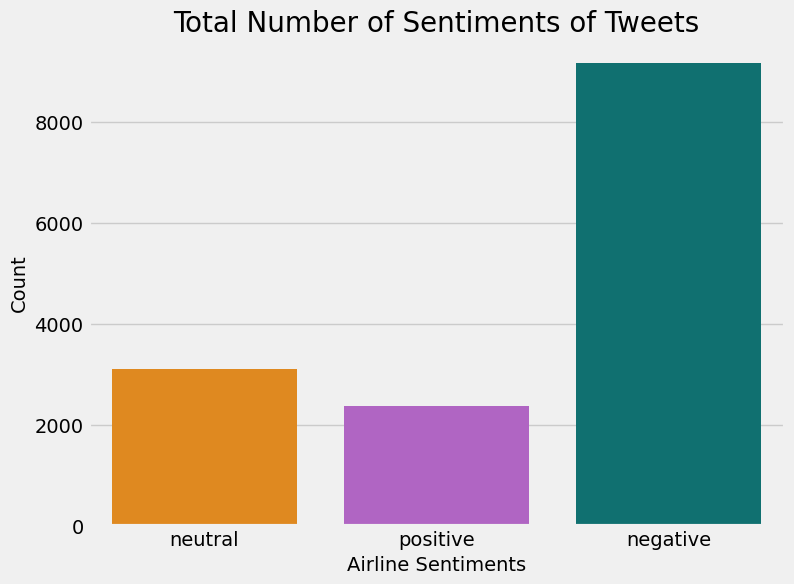

In [11]:
# Set up the plot
plt.figure(figsize=(8,6))
colors = ['DarkOrange', 'MediumOrchid', 'Teal']
ax = sns.countplot(x='airline_sentiment', data=data, palette=colors)

# Customize plot aesthetics
ax.set_title('Total Number of Sentiments of Tweets', fontsize=20)
ax.set_xlabel('Airline Sentiments', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

# Show the plot
plt.show()




## Plotting the Distribution of Text Length for Positive Sentiment Tweets

This code snippet aims to visualize the distribution of text length for tweets with positive sentiment. The steps are as follows:

1. **Create a Figure:**
   - A figure is initialized to define the plotting area.

2. **Calculate Text Length:**
   - The length of each tweet's text is computed by splitting the text into words and counting them.

3. **Create a Histogram Plot:**
   - A histogram plot is created to represent the distribution of text length for tweets with positive sentiment. The color is set to red for visual distinction.

4. **Calculate and Display Statistics:**
   - Descriptive statistics (e.g., mean, median, etc.) for the text length of positive sentiment tweets are calculated and rounded to two decimal places.

5. **Create a Table for Statistics:**
   - A table is generated to display the calculated statistics for positive sentiment tweet lengths. This table provides a concise summary of the data.

6. **Set Figure Title:**
   - A title is set for the figure, describing the purpose of the visualization.

7. **Adjust Spacing:**
   - Spacing is adjusted for better layout and readability.

8. **Display the Plot:**
   - The final plot, including the histogram and statistics table, is displayed.



## Analyzing Text Length in Positive Sentiment Tweets

This visualization provides insights into the distribution of text length in tweets with a positive sentiment. On the right, you can see a table with statistics describing the text length, including the count, mean, standard deviation, minimum, and maximum. On the left, there's a histogram showing the distribution of text lengths for positive sentiment tweets, depicted in green. This analysis helps understand the typical length of text in positive sentiment tweets.

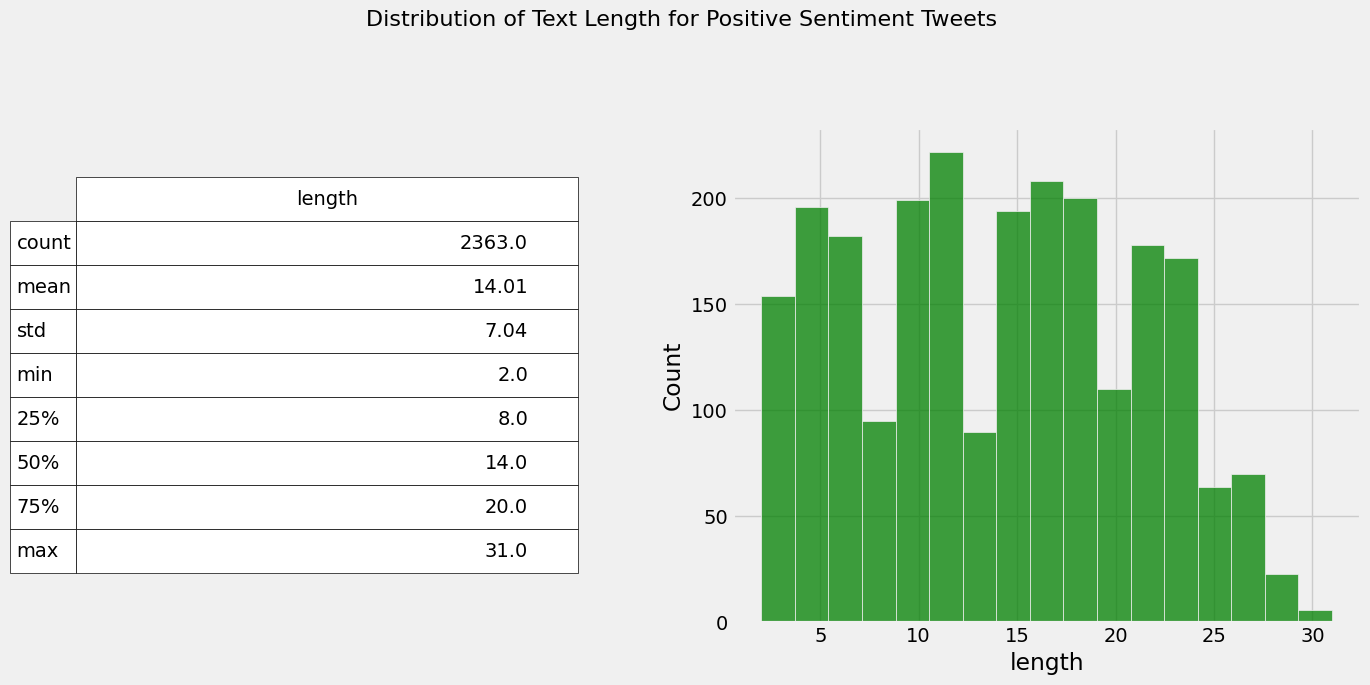

In [12]:
# Create a figure
fig = plt.figure(figsize=(14, 7))

# Calculate the length of each tweet
data['length'] = data['text'].str.split().apply(len)

# Create the histogram plot
ax1 = fig.add_subplot(122)
sns.histplot(data[data['airline_sentiment'] == 'positive']['length'], ax=ax1, color='green')

# Describe statistics for positive sentiment tweet lengths
describe = data[data['airline_sentiment'] == 'positive']['length'].describe().to_frame().round(2)

# Create a table to display statistics
ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14  # Adjust the font size if needed
bbox = [0.1, 0.1, 0.8, 0.8]  # Adjust the bounding box for table placement
table = ax2.table(cellText=describe.values, rowLabels=describe.index, bbox=bbox, colLabels=describe.columns)
table.auto_set_font_size(False)
table.set_fontsize(font_size)

# Set the figure title
fig.suptitle('Distribution of Text Length for Positive Sentiment Tweets', fontsize=16)

# Adjust spacing for better readability
plt.tight_layout(rect=[0, 0, 1, 0.9])

# Show the plot
plt.show()


**Based on our analysis of the chart, we find that the average word count for positive expressions is approximately 14 words. Additionally, it's observed that the occurrence of phrases exceeding 30 words is quite rare.**

## Analyzing Text Length in Negative Sentiment Tweets

This visualization provides insights into the distribution of text length in tweets with a negative sentiment. On the right, you can see a table with statistics describing the text length, including the count, mean, standard deviation, minimum, and maximum. On the left, there's a histogram showing the distribution of text lengths for negative sentiment tweets, depicted in red. This analysis helps understand the typical length of text in negative sentiment tweets.

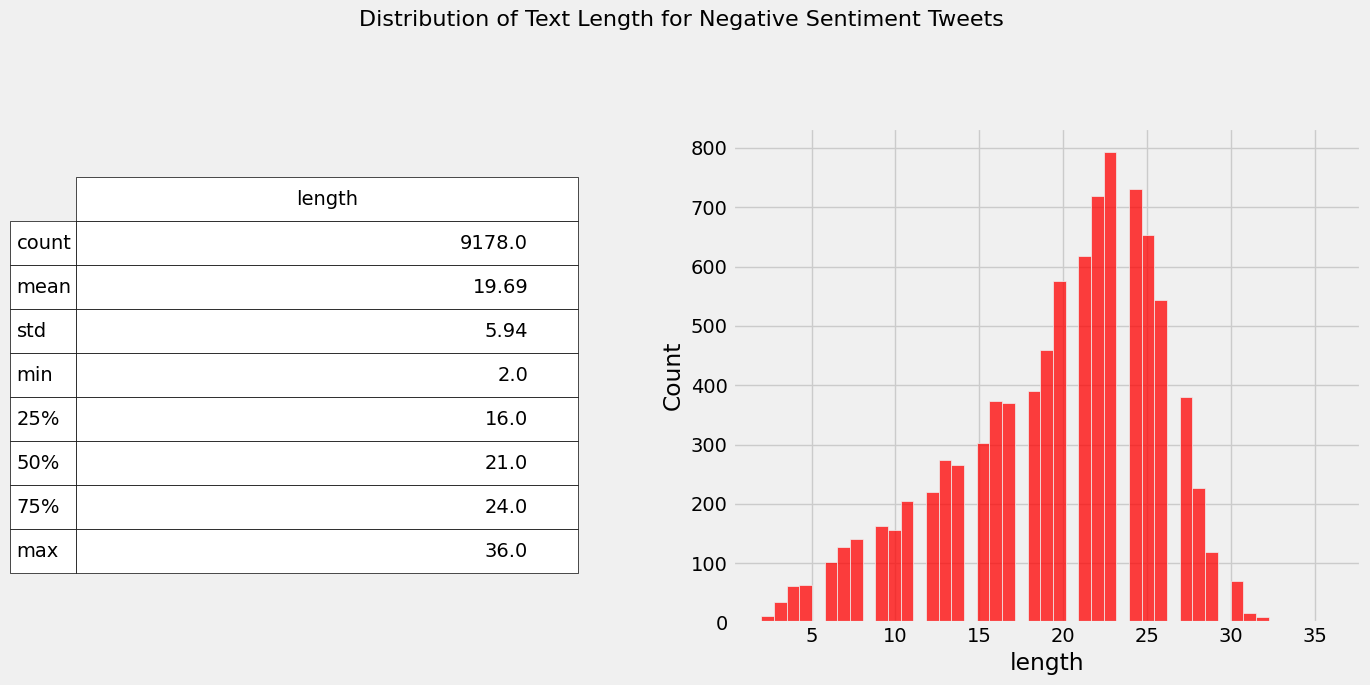

In [13]:
# Create a figure
fig = plt.figure(figsize=(14, 7))

# Calculate the length of each tweet
data['length'] = data['text'].str.split().apply(len)

# Create the histogram plot
ax1 = fig.add_subplot(122)
sns.histplot(data[data['airline_sentiment'] == 'negative']['length'], ax=ax1, color='red')

# Describe statistics for negative sentiment tweet lengths
describe = data[data['airline_sentiment'] == 'negative']['length'].describe().to_frame().round(2)

# Create a table to display statistics
ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14  # Adjust the font size if needed
bbox = [0.1, 0.1, 0.8, 0.8]  # Adjust the bounding box for table placement
table = ax2.table(cellText=describe.values, rowLabels=describe.index, bbox=bbox, colLabels=describe.columns)
table.auto_set_font_size(False)
table.set_fontsize(font_size)

# Set the figure title
fig.suptitle('Distribution of Text Length for Negative Sentiment Tweets', fontsize=16)

# Adjust spacing for better readability
plt.tight_layout(rect=[0, 0, 1, 0.9])

# Show the plot
plt.show()


**Based on our analysis of the chart, we find that the average word count for negative expressions is approximately 20 words. Furthermore, it's evident that phrases exceeding 36 words are infrequent.**

## Airline Sentiments for Each Airline

To gain insights into the sentiments associated with different airlines, we will follow a two-step approach:



## Airline Sentiments for Each Airline

To gain insights into the sentiments associated with different airlines, we will follow a two-step approach:

1. **Total Number of Tweets for Each Airline:**
   - Calculate and analyze the total number of tweets attributed to each airline.
   - This initial step provides us with a fundamental understanding of the dataset's distribution among various airlines.




In [14]:
# Print total number of tweets for each airline
airline_tweet_counts = data.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False)
print("Total number of tweets for each airline:\n", airline_tweet_counts)


Total number of tweets for each airline:
 airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64


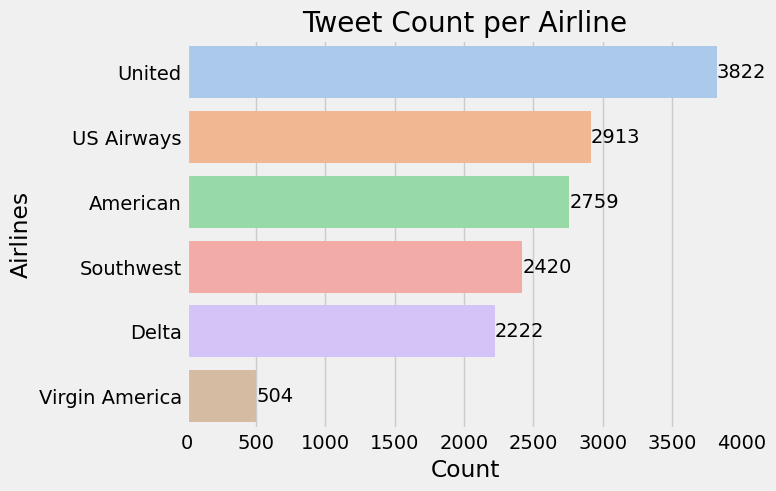

In [15]:
# Create the count plot
ax = sns.countplot(data=data, y='airline', order=data.airline.value_counts().index, palette='pastel')

# Add labels on the bars
ax.bar_label(ax.containers[0])

# Set plot title and labels
ax.set_title('Tweet Count per Airline')
ax.set_xlabel('Count')
ax.set_ylabel('Airlines')

# Show the plot
plt.show()


2. **Sentiment Distribution Barplots for Each Airline:**
   - Create barplots for each airline that showcase the distribution of sentiments (positive, negative, neutral) among the tweets.
   - These barplots offer a comprehensive visual representation of the relationships between airlines and the sentiments expressed by customers.

This combined analysis will provide valuable insights into the sentiments associated with each airline, enabling a clearer understanding of how different airlines are perceived by customers.

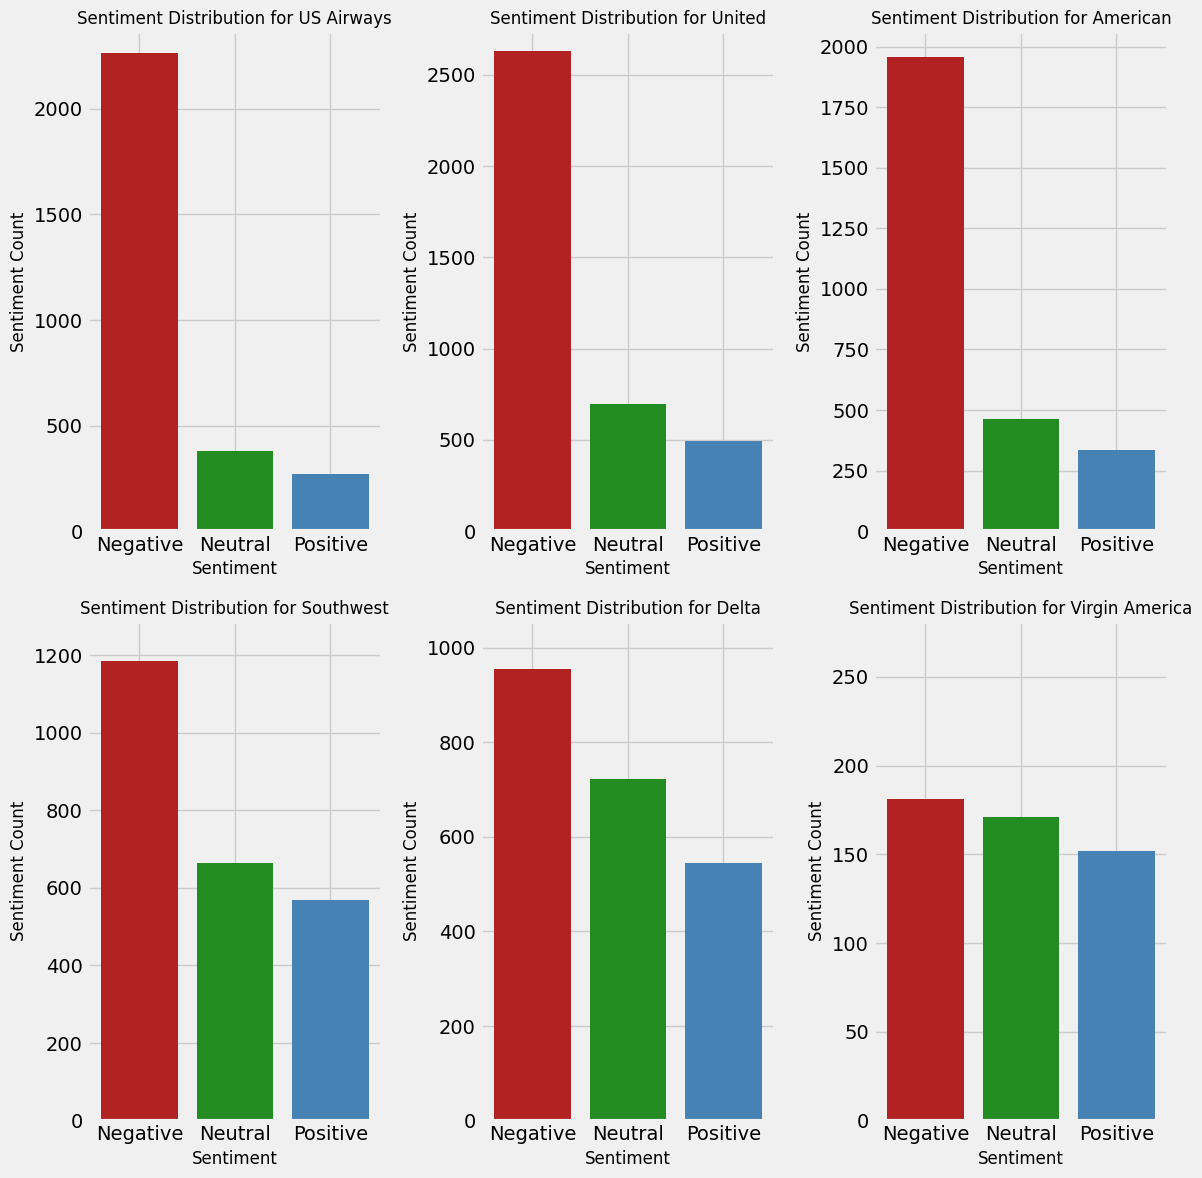

In [16]:
# List of airlines in desired order
airlines = ['US Airways', 'United', 'American', 'Southwest', 'Delta', 'Virgin America']

# Define custom colors for the bars
colors = ['firebrick', 'forestgreen', 'steelblue']

# Create a 2x3 grid of subplots for each airline
plt.figure(figsize=(12,12))
for idx, airline in enumerate(airlines, start=1):
    plt.subplot(2, 3, idx)
    airline_df = data[data['airline'] == airline]
    sentiment_count = airline_df['airline_sentiment'].value_counts()
    plt.bar(sentiment_count.index, sentiment_count, color=colors)
    plt.xticks(sentiment_count.index, ['Negative', 'Neutral', 'Positive'])
    plt.ylabel('Sentiment Count',fontsize=12)
    plt.xlabel('Sentiment',fontsize=12)
    plt.title('Sentiment Distribution for '+ airline,fontsize=12)
    plt.ylim(0, max(sentiment_count) + 100)  # Adjust y-axis limit for better visualization

plt.tight_layout()
plt.show()


 - United, US Airways, American substantially get negative reactions.
 - Tweets for Virgin America are the most balanced.


## Visualizing Negative Sentiment Reasons

To gain insights into the reasons behind negative sentiment tweets, we employ the following visualization:


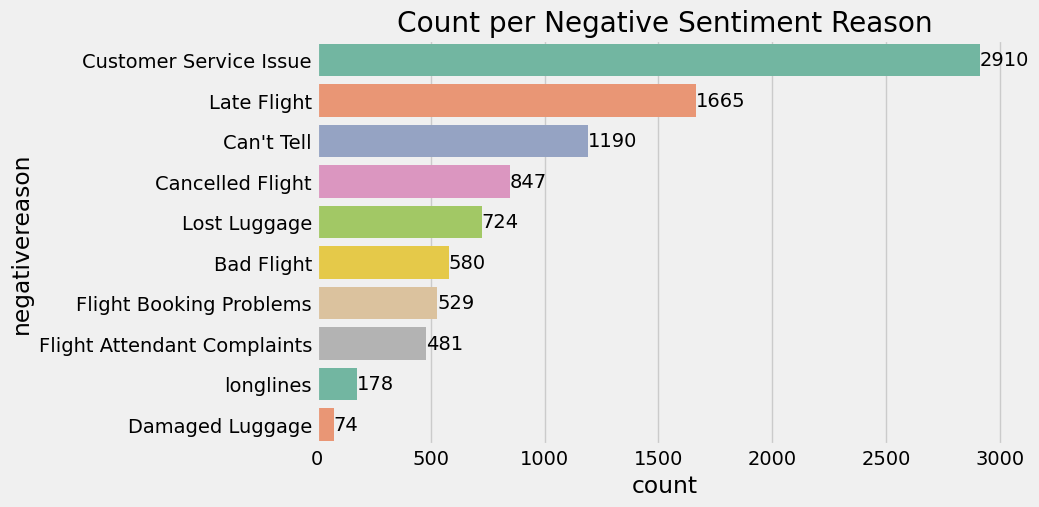

In [17]:
# Create a DataFrame for negative sentiment tweets
df_neg = data[data.airline_sentiment == 'negative']

# Create a figure for the plot
plt.figure(figsize=(8, 5))

# Generate a countplot to visualize negative sentiment reasons
ax = sns.countplot(data=df_neg, y='negativereason',
                   palette='Set2',
                   order=df_neg.negativereason.value_counts().index)

# Add labels to the bars
ax.bar_label(ax.containers[0])

# Set the plot title
ax.set_title('Count per Negative Sentiment Reason')

# Show the plot
plt.show()



**Customer service issue, as a whole, is the main reason for the negative sentiment to the airlines.**




## Breakdown of Negative Sentiment Reasons by Airline



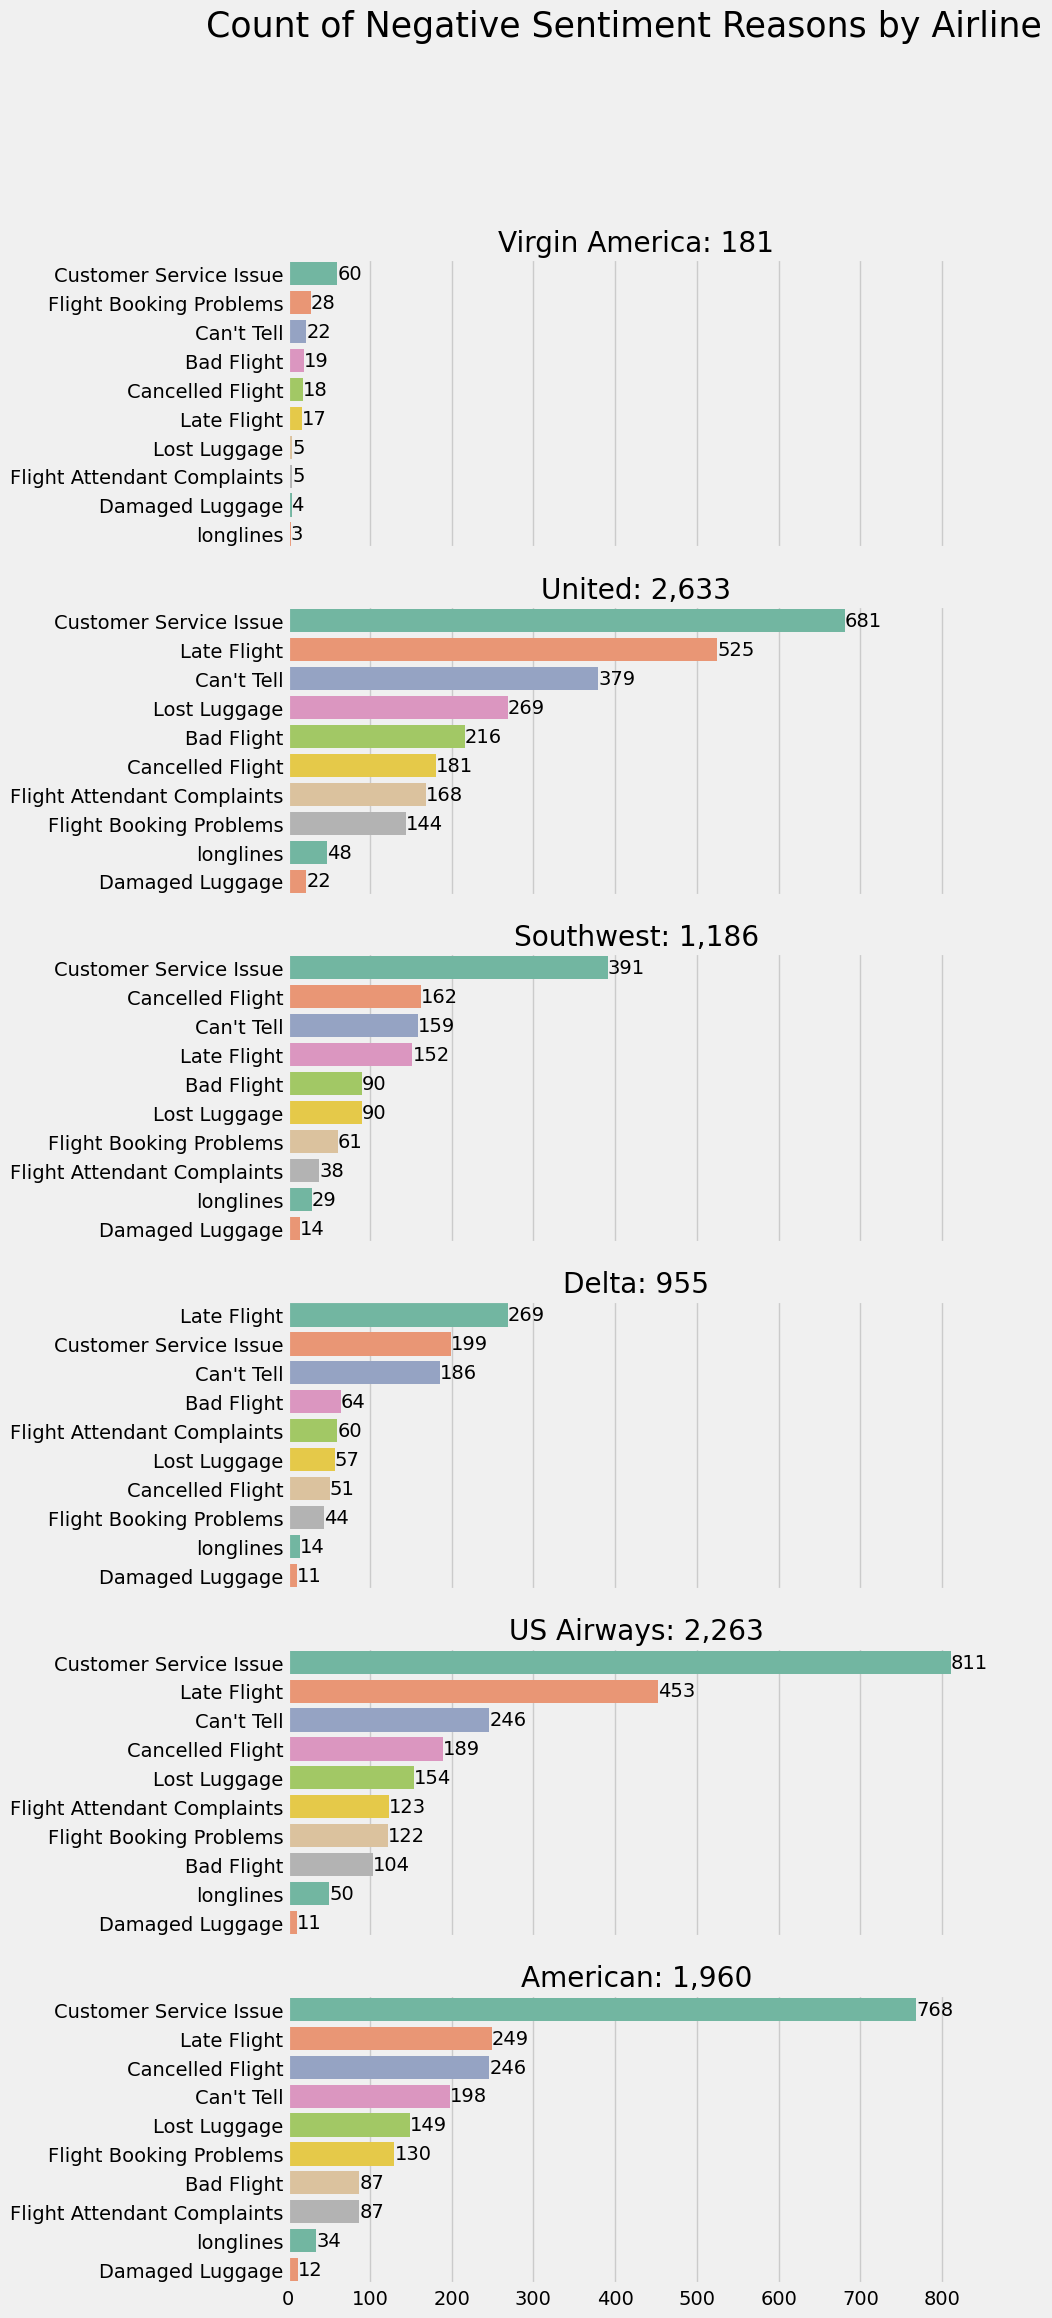

In [18]:
# Create subplots for each airline
fig, axes = plt.subplots(6, 1, figsize=(8, 25), sharex=True)
axes = axes.flatten()

# Get unique airline names
names = df_neg['airline'].unique()

# Loop through each airline to create a countplot
for name, ax in zip(names, axes):
    ax = sns.countplot(data=df_neg[df_neg.airline == name], y='negativereason',
                       palette='Set2',
                       order=df_neg[df_neg.airline == name].negativereason.value_counts().index, ax=ax)

    # Add labels to the bars
    ax.bar_label(ax.containers[0])

    # Set the title with the airline name and the count of negative sentiment tweets for that airline
    ax.set_title(f"{name}: {format(len(df_neg[df_neg.airline == name]), ',')}")

    ax.set_xlabel('')
    ax.set_ylabel('')

# Set the main title for the entire plot
plt.suptitle("Count of Negative Sentiment Reasons by Airline", fontsize=25)

# Show the plot
plt.show()


## Comparative Analysis of Negative Sentiment Reasons by Airline

To conduct a comprehensive comparative analysis of negative sentiment reasons across different airlines:



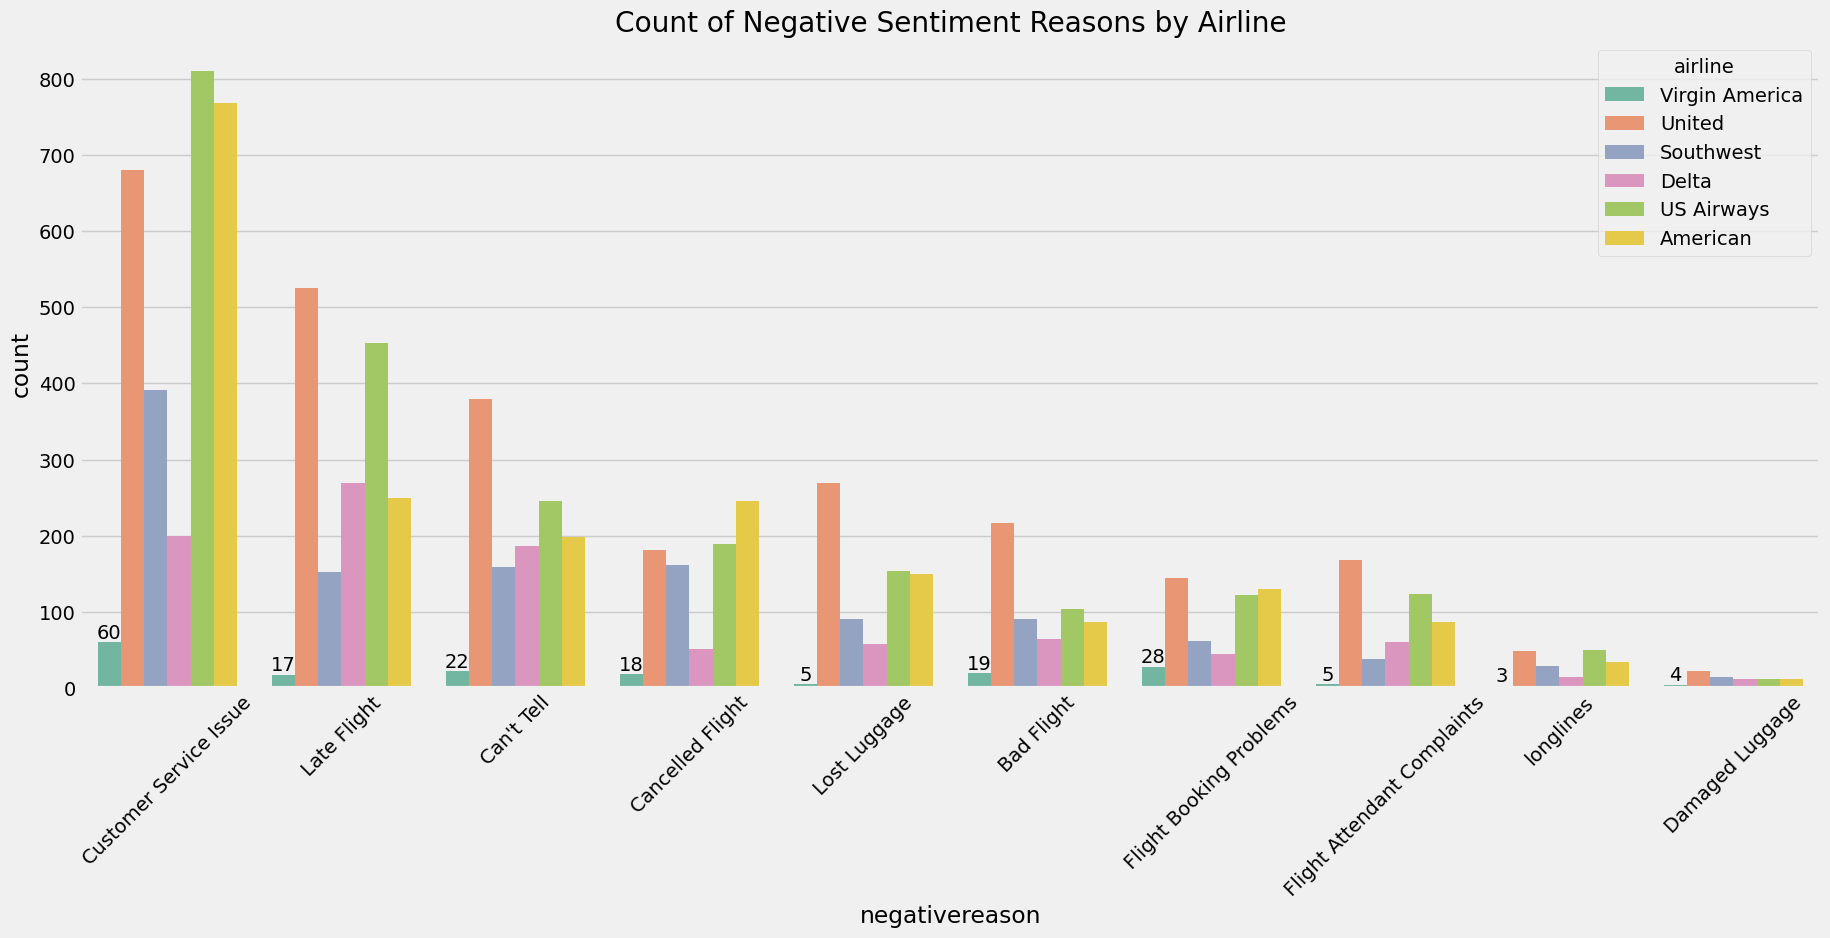

In [19]:
# Create a figure for the plot
plt.figure(figsize=(20, 8))

# Generate a countplot to visualize negative sentiment reasons with hue by airline
ax = sns.countplot(data=df_neg, x='negativereason',
                   palette='Set2',
                   order=df_neg.negativereason.value_counts().index, hue='airline')

# Add labels to the bars
ax.bar_label(ax.containers[0])

# Set the plot title
ax.set_title('Count of Negative Sentiment Reasons by Airline')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


## Percentage of Negative Sentiment Customers by Airline


In [20]:
# Get unique airline names
names = data.airline.unique()

# Loop through each airline and calculate the percentage of negative sentiment customers
for name in names:
    total_customers = len(data[data.airline == name])
    negative_customers = len(df_neg[df_neg.airline == name])
    percentage_negative = (negative_customers / total_customers) * 100
    print(f"{name}: Out of a total of {format(total_customers, ',')} customers, {percentage_negative:.1f}% express negative sentiment.\n")


Virgin America: Out of a total of 504 customers, 35.9% express negative sentiment.

United: Out of a total of 3,822 customers, 68.9% express negative sentiment.

Southwest: Out of a total of 2,420 customers, 49.0% express negative sentiment.

Delta: Out of a total of 2,222 customers, 43.0% express negative sentiment.

US Airways: Out of a total of 2,913 customers, 77.7% express negative sentiment.

American: Out of a total of 2,759 customers, 71.0% express negative sentiment.



<br>

* **`American`, `US Airways`, `Southwest`**: Complaints about customer sevice issue is relatively high.

* **`United`** : Customer service issue is the most, but customers for this airline experienced late flight more frequently than others. Lost luggage issue happened relatively high.

* **`Delta`**: Customer service looks not bad, but most of customers experienced late flight.

* **`Virgin America`**: Mostly about customer service followed by flight booking problem.

## Most used words in Positive and Negative tweets

Wordcloud is a great tool for visualizing nlp data. The larger the words in the wordcloud image , the more is the frequency of that word in our text data.

In [21]:
from wordcloud import WordCloud,STOPWORDS

- The goal is to firstly get an idea of the most frequent words in negative tweets.
- Get idea about most frequent words in positive tweets.

### Wordcloud for Negative sentiments of tweets

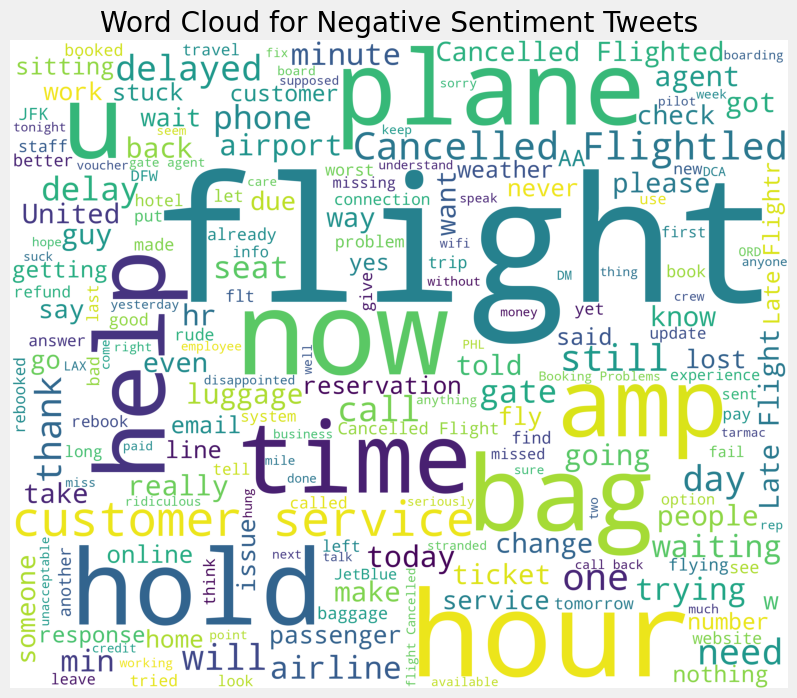

In [22]:
new_df=data[data['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
# Create a figure for the WordCloud plot
plt.figure(figsize=(10,8))

# Display the WordCloud
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment Tweets')
plt.show()

The main words we can see in the Flight of negative sentiment is 'plane', 'bag', 'time', 'customer', 'service', etc.



### Wordcloud for Positive  sentiments of tweets

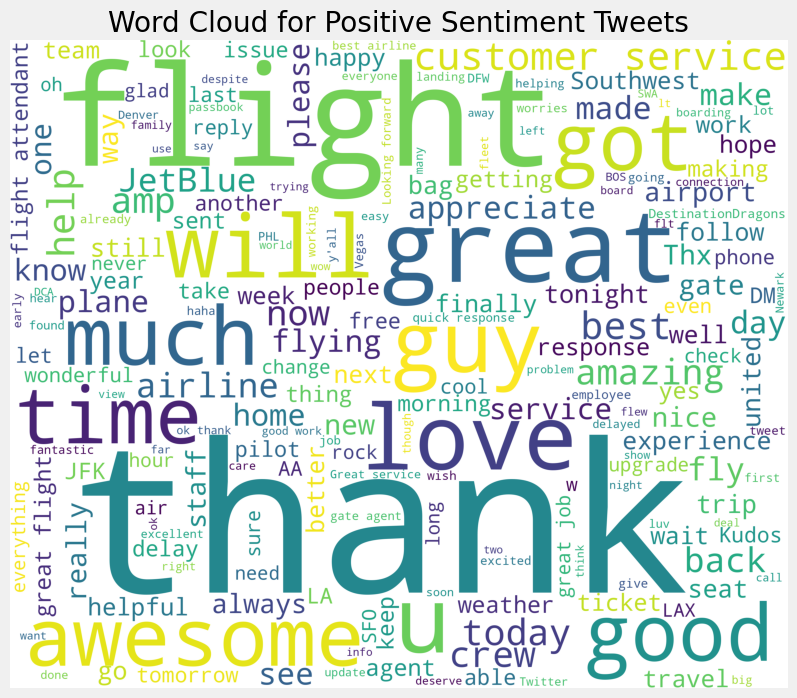

In [23]:
new_df=data[data['airline_sentiment']=='positive']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
# Create a figure for the WordCloud plot
plt.figure(figsize=(10,8))

# Display the WordCloud
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment Tweets')
plt.show()

We can see many positive words such as 'thank', 'great', 'love', etc.

### What are the reasons for negative sentimental tweets for each airline ?

We will explore the **negative reason** column of our dataframe to extract conclusions about negative sentiments in the tweets by the customers

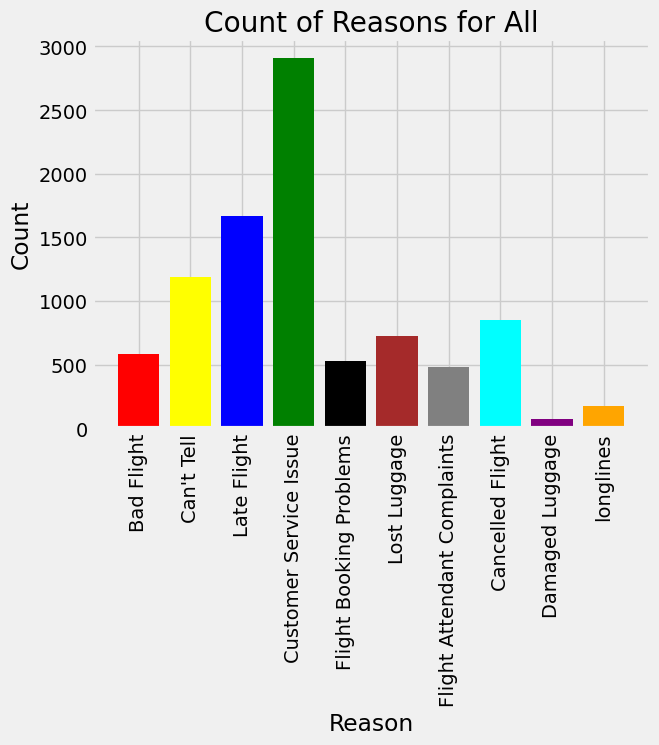

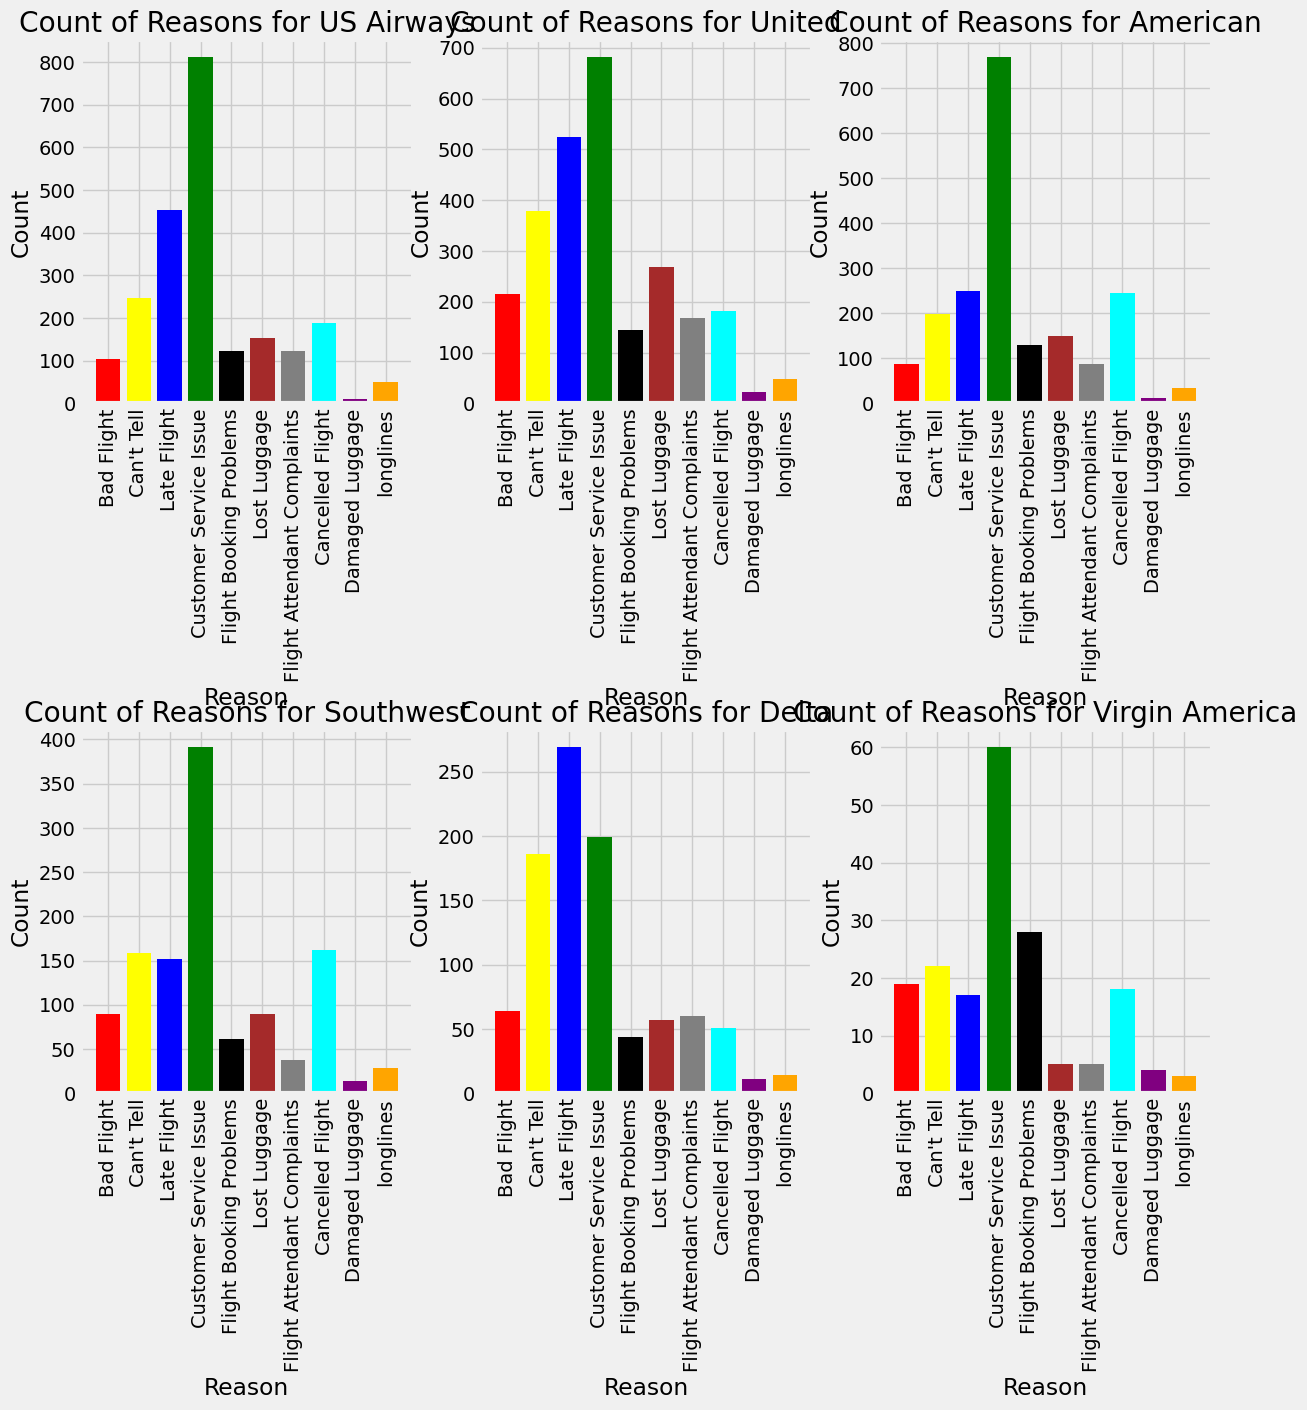

In [24]:
#get the number of negative reasons
data['negativereason'].nunique()

NR_Count=dict(data['negativereason'].value_counts(sort=False))
def NR_Count(Airline):
    if Airline=='All':
        a=data
    else:
        a=data[data['airline']==Airline]
    count=dict(a['negativereason'].value_counts())
    Unique_reason=list(data['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame
def plot_reason(Airline):

    a=NR_Count(Airline)
    count=a['count']
    Index = range(1,(len(a)+1))
    plt.bar(Index,count, color=['red','yellow','blue','green','black','brown','gray','cyan','purple','orange'])
    plt.xticks(Index,a['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)

plot_reason('All')
plt.figure(2,figsize=(13, 13))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)



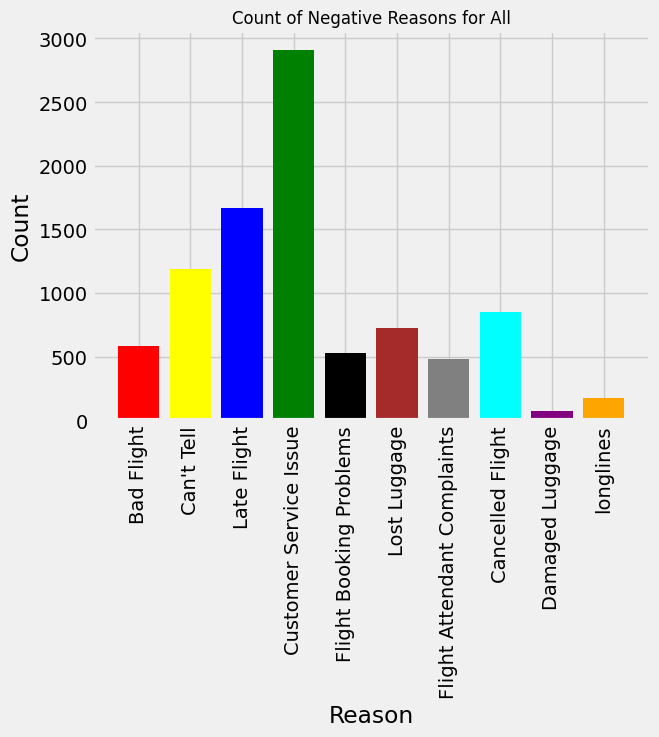

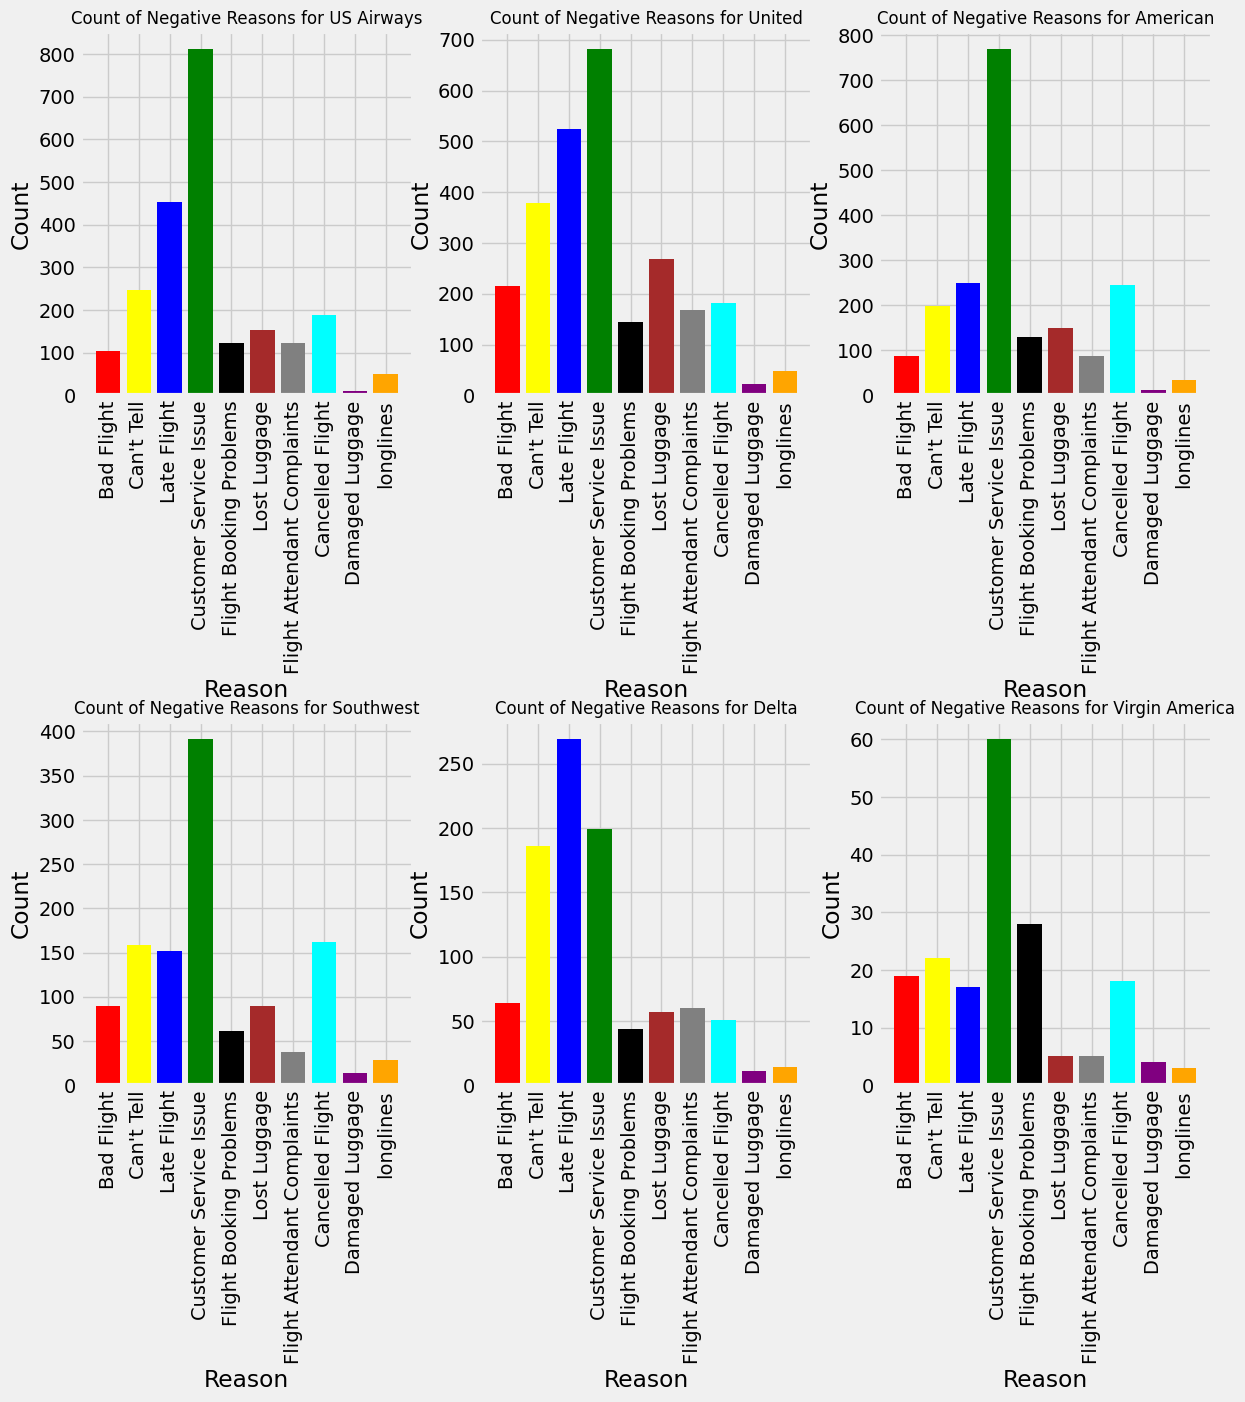

In [25]:
import matplotlib.pyplot as plt

# Get the number of unique negative reasons
num_unique_reasons = data['negativereason'].nunique()

# Function to count negative reasons
def count_negative_reasons(airline='All'):
    if airline == 'All':
        filtered_data = data
    else:
        filtered_data = data[data['airline'] == airline]

    # Count the occurrences of each negative reason
    reason_counts = dict(filtered_data['negativereason'].value_counts())

    # Get unique reasons and filter out NaN if present
    unique_reasons = [x for x in data['negativereason'].unique() if str(x) != 'nan']

    # Create a DataFrame to store reasons and their counts
    reason_frame = pd.DataFrame({'Reasons': unique_reasons})
    reason_frame['Count'] = reason_frame['Reasons'].apply(lambda x: reason_counts[x])

    return reason_frame

# Function to plot negative reasons
def plot_negative_reason(airline='All'):
    reason_data = count_negative_reasons(airline)

    # Create a bar plot to visualize the count of reasons

    plt.bar(reason_data['Reasons'], reason_data['Count'],
            color=['red', 'yellow', 'blue', 'green', 'black', 'brown', 'gray', 'cyan', 'purple', 'orange'])
    plt.xticks(rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title(f'Count of Negative Reasons for {airline}',fontsize=12)

# Plot the count of negative reasons for all airlines
plot_negative_reason()

# Create subplots for each airline
plt.figure(figsize=(13, 13))
for airline in airlines:
    indices = airlines.index(airline)
    plt.subplot(2, 3, indices + 1)
    plt.subplots_adjust(hspace=0.9)
    plot_negative_reason(airline)


- Customer Service Issue is the main neagtive reason for US Airways,United,American,Southwest,Virgin America
- Late Flight is the main negative reason for Delta  
- Interestingly, Virgin America has the least count of negative reasons (all less than 60)
- Contrastingly to Virgin America, airlines like US Airways,United,American have more than 500 negative reasons (Late flight, Customer Service Issue)

## Text Preprocessing


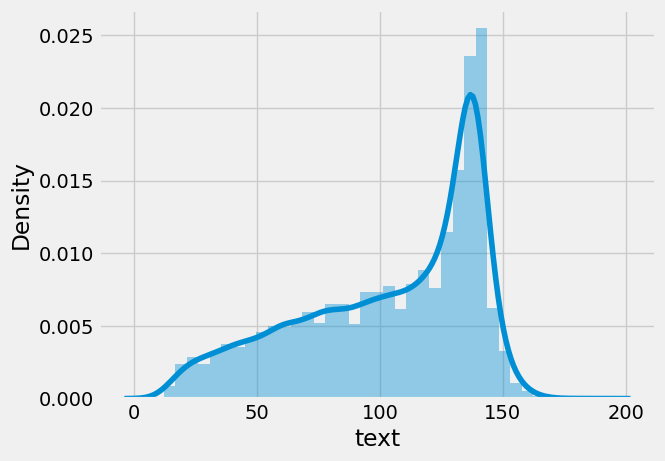

In [26]:
sns.distplot(data.text.str.len())

plt.show()

* Tweet text is consisted of 103 length in average.
* Minimum length is 12, and maximum one is 186.

## Descriptive Statistics of Tweet Length

In [27]:
data.text.str.len().describe()

count    14640.000000
mean       103.822063
std         36.277339
min         12.000000
25%         77.000000
50%        114.000000
75%        136.000000
max        186.000000
Name: text, dtype: float64

## Exploring Tweet Text


In [28]:
# Display the text of the first tweet
print(data['text'][0].split(), '\n')

# Display the text of the second tweet
print(data['text'][1].split(), '\n')

# Display the text of the 100th tweet
print(data['text'][100].split(), '\n')

# Display the text of the 1000th tweet
print(data['text'][1000].split(), '\n')

# Display the text of the 10000th tweet
print(data['text'][10000].split())


['@VirginAmerica', 'What', '@dhepburn', 'said.'] 

['@VirginAmerica', 'plus', "you've", 'added', 'commercials', 'to', 'the', 'experience...', 'tacky.'] 

['@VirginAmerica', 'trying', 'to', 'add', 'my', 'boy', 'Prince', 'to', 'my', 'ressie.', 'SF', 'this', 'Thursday', '@VirginAmerica', 'from', 'LAX', 'http://t.co/GsB2J3c4gM'] 

['@united', 'how', 'can', 'you', 'not', 'put', 'my', 'bag', 'on', 'plane', 'to', 'Seattle.', 'Flight', '1212.', 'Waiting', 'in', 'line', 'to', 'talk', 'to', 'someone', 'about', 'my', 'bag.', 'Status', 'should', 'matter.'] 

['@USAirways', 'waiting', 'all', 'day', 'at', 'ATL', 'since', 'flight', 'this', 'am', 'Cancelled', 'Flightled.', '1', 'standby', 'told', 'no', 'seats', 'and', 'group', 'of', '15', 'shows', 'up', 'Late', 'Flight', 'and', 'gets', 'on', 'to', 'PHL']


## Text Preprocessing Functions

In [29]:
def clean_text(d):
    pattern = r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', d)
    return text

names = ['delta', 'deltaair', 'united', 'unitedair', 'southwest', 'southwestair', 'usairways',
         'virginamerica', 'american', 'americanair', 'jetblue', 'jetblues', 'usairway',
         'flight', 'airline', 'airlines']

# I thought the words related the name of airlines are not relevant to the sentiment analysis
# Therefore I decided to append the above names into the list of stop words.
def clean_stopword(d):
    stop_words = stopwords.words('english')
    for name in names:
        stop_words.append(name)
    return " ".join([w.lower() for w in d.split() if w.lower() not in stop_words and len(w) > 1])

def tokenize(d):
    return word_tokenize(d)

In [30]:
import nltk


data['final_text']= data.text.apply(clean_text).apply(clean_stopword).apply(tokenize)
data.final_text.head()

0                                     [dhepburn, said]
1    [plus, youve, added, commercials, experience, ...
2    [didnt, today, must, mean, need, take, another...
3    [really, aggressive, blast, obnoxious, enterta...
4                            [really, big, bad, thing]
Name: final_text, dtype: object

In [31]:
# Display the text of the first tweet as a single sentence
print(" ".join(data['final_text'][0]), '\n')

# Display the text of the second tweet as a single sentence
print(" ".join(data['final_text'][1]), '\n')

# Display the text of the 100th tweet as a single sentence
print(" ".join(data['final_text'][100]), '\n')

# Display the text of the 1000th tweet as a single sentence
print(" ".join(data['final_text'][1000]), '\n')

# Display the text of the 10000th tweet as a single sentence
print(" ".join(data['final_text'][10000]))


dhepburn said 

plus youve added commercials experience tacky 

trying add boy prince ressie sf thursday lax httptcogsbjcgm 

put bag plane seattle waiting line talk someone bag status matter 

waiting day atl since cancelled flightled standby told seats group shows late gets phl


## Sentiment Analysis Using VADER SentimentIntensityAnalyzer

In [32]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

vader = SentimentIntensityAnalyzer()
vader.polarity_scores(" ".join(data.final_text[0]))

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

## Sentiment Analysis Results Using VADER SentimentIntensityAnalyzer

In [33]:
texts = [" ".join(data.final_text[i]) for i in range(len(data))]

print(data.text[0])
print(texts[0])
print(vader.polarity_scores(texts[0]), f'--> Actual Classification: {data.airline_sentiment[0]}', '\n')

print(data.text[1])
print(texts[1])
print(vader.polarity_scores(texts[1]), f'--> Actual Classification: {data.airline_sentiment[1]}', '\n')

print(data.text[10])
print(texts[10])
print(vader.polarity_scores(texts[10]), f'--> Actual Classification: {data.airline_sentiment[10]}', '\n')

print(data.text[100])
print(texts[100])
print(vader.polarity_scores(texts[100]), f'--> Actual Classification: {data.airline_sentiment[100]}', '\n')

print(data.text[1000])
print(texts[1000])
print(vader.polarity_scores(texts[1000]), f'--> Actual Classification: {data.airline_sentiment[1000]}', '\n')

print(data.text[10000])
print(texts[10000])
print(vader.polarity_scores(texts[10000]), f'--> Actual Classification: {data.airline_sentiment[10000]}')

@VirginAmerica What @dhepburn said.
dhepburn said
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} --> Actual Classification: neutral 

@VirginAmerica plus you've added commercials to the experience... tacky.
plus youve added commercials experience tacky
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} --> Actual Classification: positive 

@VirginAmerica did you know that suicide is the second leading cause of death among teens 10-24
know suicide second leading cause death among teens
{'neg': 0.583, 'neu': 0.417, 'pos': 0.0, 'compound': -0.8555} --> Actual Classification: neutral 

@VirginAmerica trying to add my boy Prince to my ressie. SF this Thursday @VirginAmerica from LAX http://t.co/GsB2J3c4gM
trying add boy prince ressie sf thursday lax httptcogsbjcgm
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} --> Actual Classification: neutral 

@united how can you not put my bag on plane to Seattle. Flight 1212. Waiting  in line to talk to someone about my bag. Status sho

## Preprocessing for Word Clouds by Sentiment


In [34]:
# preprocessing before drawing wordcloud separating the sentiment.

positive = data[data.airline_sentiment == 'positive'].text.apply(clean_text).apply(clean_stopword).apply(tokenize)
positive = [" ".join(positive.values[i]) for i in range(len(positive))]
positive = [" ".join(positive)][0]

negative = data[data.airline_sentiment == 'negative'].text.apply(clean_text).apply(clean_stopword).apply(tokenize)
negative = [" ".join(negative.values[i]) for i in range(len(negative))]
negative = [" ".join(negative)][0]

neutral = data[data.airline_sentiment == 'neutral'].text.apply(clean_text).apply(clean_stopword).apply(tokenize)
neutral = [" ".join(neutral.values[i]) for i in range(len(neutral))]
neutral = [" ".join(neutral)][0]

print(len(positive), len(negative), len(neutral))

115931 591416 151075


<br>

### Machine Learning approach

ML approach is also known as Document Classificaton. It uses ML/DL algorithm to classify the text data.

The most important in ML approach is to convert the text to the vector or other numeric format to make the algorithms understand the text as a feature.


* Vectorization : `CountVectorizer`, `TfidfTransformer`, `Word2Vec`
* Model: Logistic Regression, RandomForest, MultinomialNB, SupportVectorMachine, BiLSTM

In [35]:
data.final_text

0                                         [dhepburn, said]
1        [plus, youve, added, commercials, experience, ...
2        [didnt, today, must, mean, need, take, another...
3        [really, aggressive, blast, obnoxious, enterta...
4                                [really, big, bad, thing]
                               ...                        
14635                     [thank, got, different, chicago]
14636    [leaving, minutes, late, warnings, communicati...
14637                          [please, bring, blackberry]
14638    [money, change, dont, answer, phones, suggesti...
14639    [ppl, need, know, many, seats, next, plz, put,...
Name: final_text, Length: 14640, dtype: object

In [36]:
for i in range(len(data)):
    data['final_text'][i] = " ".join(data['final_text'][i])

In [37]:
data['final_text'][:5]

0                                        dhepburn said
1        plus youve added commercials experience tacky
2         didnt today must mean need take another trip
3    really aggressive blast obnoxious entertainmen...
4                                 really big bad thing
Name: final_text, dtype: object

In [38]:
def convert_Sentiment(sentiment):
    if  sentiment == "positive":
        return 2
    elif sentiment == "neutral":
        return 1
    elif sentiment == "negative":
        return 0

data.airline_sentiment = data.airline_sentiment.apply(lambda x : convert_Sentiment(x))

In [39]:
X = data.final_text
y = data.airline_sentiment

## Model Comparison

In [40]:
model_params = {'random_state':42}
model_list = [LogisticRegression(**model_params, solver='liblinear'),
              RandomForestClassifier(**model_params),
              MultinomialNB(),
              SVC(**model_params)]
model_names = ['LogisticRegression', 'RandomForest', 'MultinomialNB', 'SupportVectorMachine']

c = CountVectorizer()
X_c = c.fit_transform(X)

tf = TfidfVectorizer()
X_tf = tf.fit_transform(X)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model, model_name in zip(model_list, model_names):
    for n_fold, (trn_idx, vld_idx) in enumerate(skf.split(data.index, data.airline_sentiment)):
        X_c_trn = X_c[trn_idx]
        X_tf_trn = X_tf[trn_idx]
        y_trn = data.loc[trn_idx, 'airline_sentiment']

        X_c_vld = X_c[vld_idx]
        X_tf_vld = X_tf[vld_idx]
        y_vld = data.loc[vld_idx, 'airline_sentiment']

        model.fit(X_c_trn, y_trn)
        c_pred_col = f"{model_name}_ct_pred"
        data.loc[vld_idx, c_pred_col] = model.predict(X_c_vld)

        model.fit(X_tf_trn, y_trn)
        tf_pred_col = f"{model_name}_tf_pred"
        data.loc[vld_idx, tf_pred_col] = model.predict(X_tf_vld)

    print(f"Model: {model_name}, CountVectorizer, Accuracy: {accuracy_score(data.airline_sentiment, data[c_pred_col]):.3%}")
    print(f"Model: {model_name}, TfidfVectorizer, Accuracy: {accuracy_score(data.airline_sentiment, data[tf_pred_col]):.3%}\n")

Model: LogisticRegression, CountVectorizer, Accuracy: 78.921%
Model: LogisticRegression, TfidfVectorizer, Accuracy: 76.858%

Model: RandomForest, CountVectorizer, Accuracy: 76.926%
Model: RandomForest, TfidfVectorizer, Accuracy: 76.660%

Model: MultinomialNB, CountVectorizer, Accuracy: 76.100%
Model: MultinomialNB, TfidfVectorizer, Accuracy: 68.730%

Model: SupportVectorMachine, CountVectorizer, Accuracy: 77.152%
Model: SupportVectorMachine, TfidfVectorizer, Accuracy: 76.701%



<br>

#### Word2Vec

Word2Vec is one of the most popular model to represent a word in a large text corpus as a vector in n-dimensional space.

There are two kinds of W2V, Continuous Bag-of-Words(CBOW) and Skip-Gram.

Skip-gram is used to predict the context word for a given target word. It’s reverse of CBOW algorithm. Here, target word is input while context words are output.

In most case it is known that the predictability of skip-gram is better than the one of CBOW.

We can use `Word2Vec` library from `gensim` and set the option `sg` which is the abbreviation of skip-gram.
    
* 1, if you want to set skip-gram and 0 for CBOW.

In [41]:
from gensim.models import Word2Vec

texts_w2v = data.final_text.apply(tokenize).to_list()

w2v = Word2Vec(sentences = texts_w2v, window = 3,
               vector_size = 100, min_count = 5, workers = 4, sg = 1)

In [42]:
texts_w2v[:3]

[['dhepburn', 'said'],
 ['plus', 'youve', 'added', 'commercials', 'experience', 'tacky'],
 ['didnt', 'today', 'must', 'mean', 'need', 'take', 'another', 'trip']]

<br>

`Word2Vec` imported from `gensim` trains the texts at the same time as it is declared by the user.

We can find the similar words with the given word and the examples are represented below.

<br>

In [43]:
similar_words = w2v.wv.most_similar('thank', topn=5)  # Get the top 5 most similar words

print("Words similar to 'thank':")
for word, score in similar_words:
    print(f"{word}: {score:.3f}")


Words similar to 'thank':
amazing: 0.955
much: 0.952
appreciate: 0.950
thanks: 0.938
twitter: 0.938


In [44]:
word_to_find = 'customerservice'

if word_to_find in w2v.wv:
    similar_words = w2v.wv.most_similar(word_to_find, topn=5)
    print(f"Words similar to '{word_to_find}':")
    for word, score in similar_words:
        print(f"{word}: {score:.3f}")
else:
    print(f"'{word_to_find}' is not in the vocabulary.")


Words similar to 'customerservice':
fail: 0.992
americanairlines: 0.992
pathetic: 0.990
nightmare: 0.990
zero: 0.990


In [45]:
similar_words = w2v.wv.most_similar('crew')

# Print the similar words and their similarity scores
for word, score in similar_words:
    print(f"{word}: {score:.3f}")


ground: 0.924
pilot: 0.916
attendant: 0.903
passengers: 0.896
pilots: 0.893
landing: 0.892
staff: 0.886
air: 0.883
ua: 0.882
newark: 0.874


In [46]:
similar_words = w2v.wv.most_similar('ticket', topn=5)  # Get the top 5 most similar words

print("Words similar to 'ticket':")
for word, score in similar_words:
    print(f"{word}: {score:.3f}")

Words similar to 'ticket':
fee: 0.945
refund: 0.920
name: 0.918
card: 0.916
award: 0.915


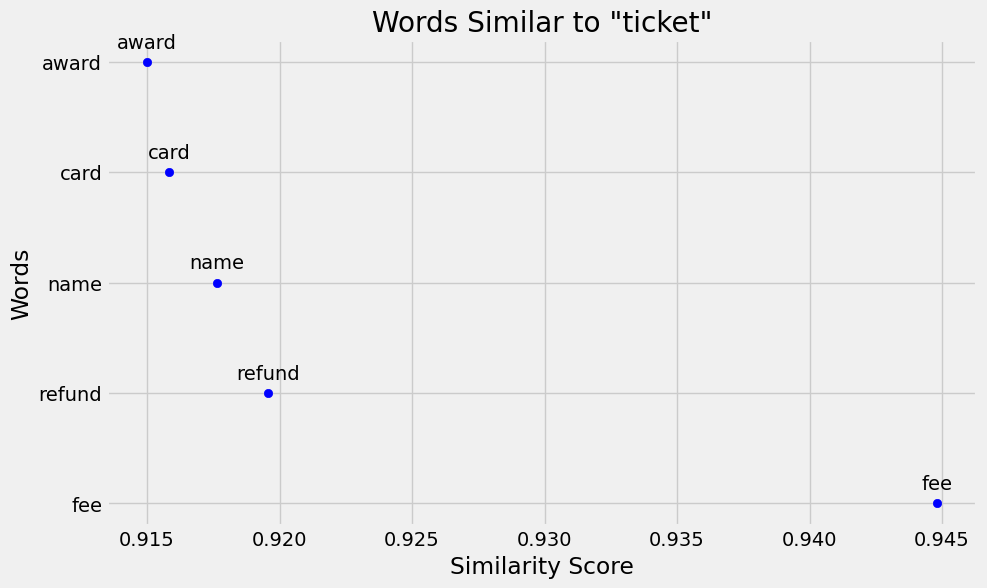

In [47]:
import matplotlib.pyplot as plt

# Get the top 5 most similar words to 'ticket'
similar_words = w2v.wv.most_similar('ticket', topn=5)

# Separate the similar words and their similarity scores
words, scores = zip(*similar_words)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(scores, words, color='b', marker='o')

# Annotate the points with the words
for i, word in enumerate(words):
    plt.annotate(word, (scores[i], word), textcoords="offset points", xytext=(0, 10), ha='center')

# Set labels and title
plt.xlabel('Similarity Score')
plt.ylabel('Words')
plt.title('Words Similar to "ticket"')

# Show the plot
plt.grid(True)
plt.show()


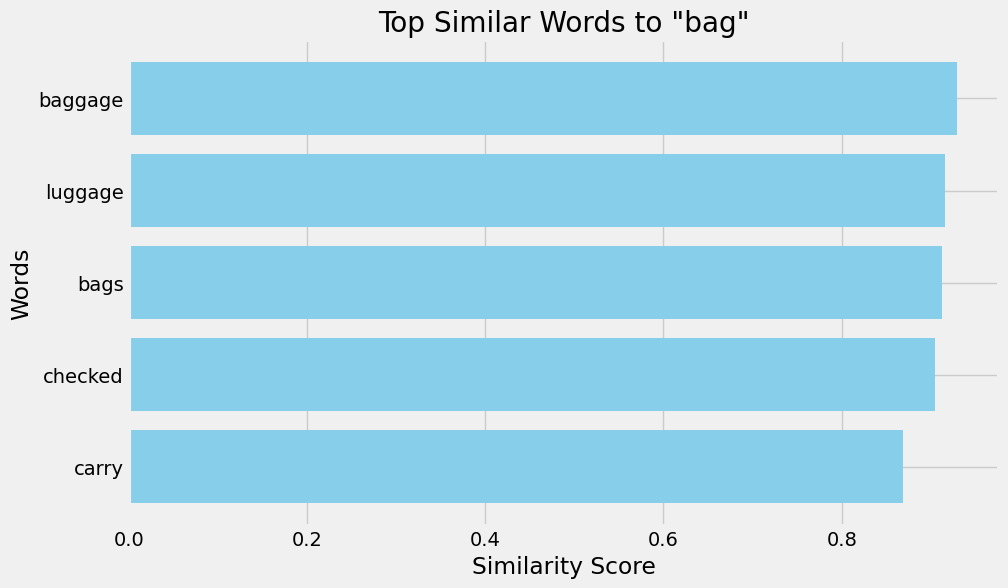

In [48]:
import matplotlib.pyplot as plt

# Get the top 5 most similar words to 'bag'
similar_words = w2v.wv.most_similar('bag', topn=5)

# Separate the similar words and their similarity scores
words, scores = zip(*similar_words)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(words, scores, color='skyblue')
plt.xlabel('Similarity Score')
plt.ylabel('Words')
plt.title('Top Similar Words to "bag"')
plt.gca().invert_yaxis()  # Reverse the order for better visualization
plt.show()



In [49]:
similar_words = w2v.wv.most_similar('booking', topn=5)  # Get the top 5 most similar words

print("Words similar to 'booking':")
for word, score in similar_words:
    print(f"{word}: {score:.3f}")

Words similar to 'booking':
reflight: 0.908
problems: 0.817
using: 0.801
fee: 0.796
ticket: 0.775


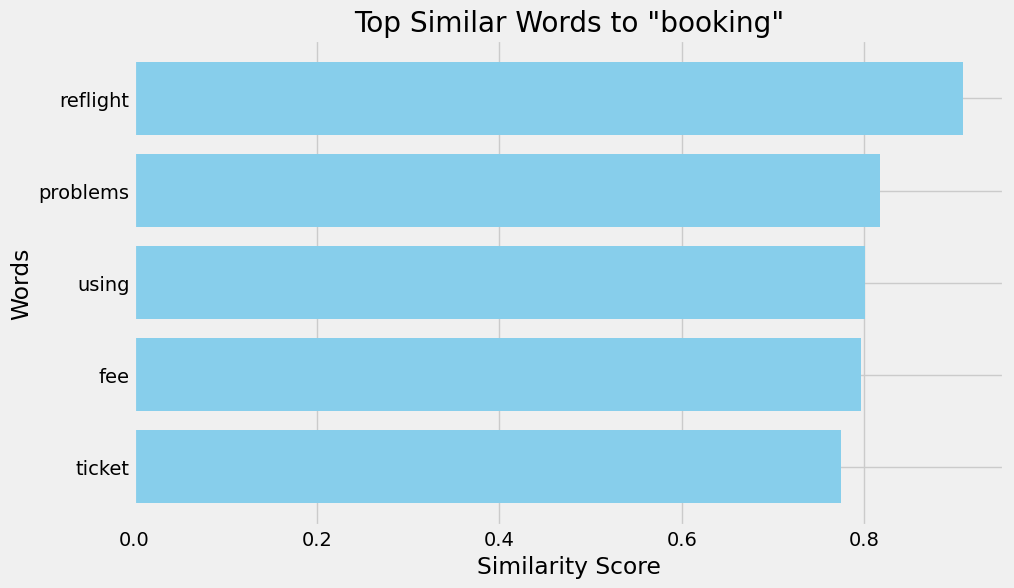

In [50]:
import matplotlib.pyplot as plt

similar_words = w2v.wv.most_similar('booking', topn=5)  # Get the top 5 most similar words

# Extract similar words and their similarity scores
words = [word for word, _ in similar_words]
scores = [score for _, score in similar_words]

# Create a bar chart to visualize the similarity scores
plt.figure(figsize=(10, 6))
plt.barh(words, scores, color='skyblue')
plt.xlabel('Similarity Score')
plt.ylabel('Words')
plt.title('Top Similar Words to "booking"')
plt.gca().invert_yaxis()  # Reverse the order for better visualization
plt.show()


## Creating Word2Vec Average Vectors

- Calculating Word2Vec average vectors for text data.

In [51]:
def get_avg_vector(sent):
    vector = np.zeros(100)
    total_words = 0
    for word in sent.split():
        if word in w2v.wv.index_to_key:    # don't use .wv.vocab method in kaggle notebook. instead, use .wv.index_to_key method.
            vector += w2v.wv.word_vec(word)
            total_words += 1
    if total_words > 0:
        return vector / total_words
    else:
        return vector

data['w2v_vector'] = data['final_text'].map(get_avg_vector)
data[['final_text', 'w2v_vector']].head(2)

,final_text,w2v_vector
0,dhepburn said,"[-0.09412930905818939, 0.1896464228630066, 0.1..."
1,plus youve added commercials experience tacky,"[0.0442483801394701, 0.14573585987091064, 0.08..."


## Word2Vec-Based Sentiment Analysis

- Trained logistic regression, random forest, and support vector machine models on Word2Vec average vectors of text data.

In [52]:
model_params = {'random_state':42}
model_list = [LogisticRegression(**model_params, solver='liblinear'),
              RandomForestClassifier(**model_params),
#               MultinomialNB(),  # Don't use Naive Bayes since w2v_vector contains negative numbers, then it causes an error.
              SVC(**model_params)]
model_name = ['LogisticRegression', 'RandomForest', 'SupportVectorMachine']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model, model_name in zip(model_list, model_name):
    for n_fold, (trn_idx, vld_idx) in enumerate(skf.split(data.index, data.airline_sentiment)):
        X_trn = np.stack(data.loc[trn_idx, 'w2v_vector'])
        y_trn = data.loc[trn_idx, 'airline_sentiment']

        X_vld = np.stack(data.loc[vld_idx, 'w2v_vector'])
        y_vld = data.loc[vld_idx, 'airline_sentiment']

        model.fit(X_trn, y_trn)
        pred_col = f"{model_name}_w2v_pred"
        data.loc[vld_idx, pred_col] = model.predict(X_vld)


    print(f"Model: {model_name}, Word2Vec, Accuracy: {accuracy_score(data.airline_sentiment, data[pred_col]):.3%}\n")

Model: LogisticRegression, Word2Vec, Accuracy: 71.134%

Model: RandomForest, Word2Vec, Accuracy: 73.292%

Model: SupportVectorMachine, Word2Vec, Accuracy: 70.007%



**We found that the results aren't be improved on the traditional ML algorithms.**

**It is known that effect from using embedding vector like Word2Vec usually maximizes by using sequence model like RNN.**

**I will try BiLSTM.**


LSTM, or Long Short-Term Memory, is a type of neural network designed to understand and learn patterns in sequences of data. It's especially good at handling long sequences and has applications in tasks like language processing and time series prediction. It uses memory cells and gates to control information flow, making it effective in capturing long-term dependencies.

## Text Tokenization and Padding

- Tokenized and padded the text data to prepare it for input into machine learning models.
- Limited the maximum number of words to 5,000 and the maximum sequence length to 100.

In [53]:
max_words = 5000
max_len = 100

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', data['final_text'][0],'\n')
X, tokenizer = tokenize_pad_sequences(data['final_text'])
print('After Tokenization & Padding \n', X[0])


Before Tokenization & Padding 
 dhepburn said 

After Tokenization & Padding 
 [125   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


## Data Splitting

- The dataset has been split into training, validation, and test sets.
- The training set contains **X_trn** samples and **y_trn** labels.
- The validation set contains **X_vld** samples and **y_vld** labels.
- The test set contains **X_tst** samples and **y_tst** labels.
- This splitting ensures that the data is divided for training, hyperparameter tuning (validation), and final evaluation (testing) of machine learning models.

In [54]:
y = pd.get_dummies(data.airline_sentiment)
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, test_size=0.3, random_state=42, stratify=y_trn)

print('Train:         ', X_trn.shape, y_trn.shape)
print('Validation Set:', X_vld.shape, y_vld.shape)
print('Test Set:      ', X_tst.shape, y_tst.shape)

Train:          (8198, 100) (8198, 3)
Validation Set: (3514, 100) (3514, 3)
Test Set:       (2928, 100) (2928, 3)


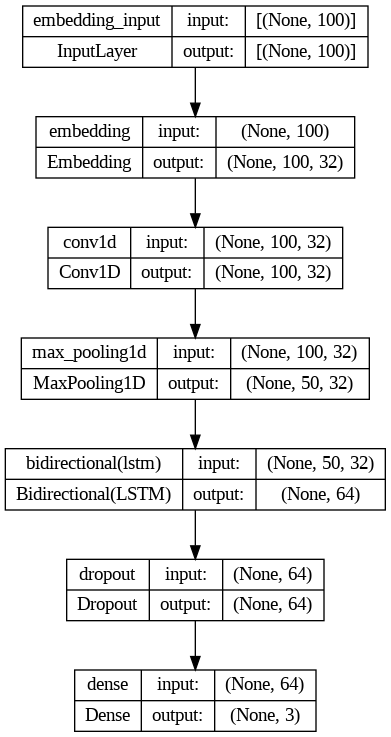

In [55]:
vocab_size = 5000
embedding_size = 32
epochs=50

model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

plot_model(model, show_shapes = True)

In [56]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           160000    
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 32)            0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 1

## Model Training

- The model has been trained with the following settings:
  - Batch Size: 64
  - Early Stopping: Monitoring validation loss with patience of 5 epochs.

- The training history, including loss and accuracy, is stored in the `history` variable for further analysis and visualization.

In [57]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5)
batch_size = 64

history = model.fit(X_trn, y_trn,
                    validation_data=(X_vld, y_vld),
                    batch_size=batch_size, epochs=epochs, verbose=1,
                    callbacks=[es])

Epoch 1/50
129/129 [==============================] - 14s 79ms/step - loss: 0.8463 - accuracy: 0.6316 - val_loss: 0.6758 - val_accuracy: 0.6989
Epoch 2/50
129/129 [==============================] - 7s 56ms/step - loss: 0.5987 - accuracy: 0.7525 - val_loss: 0.5898 - val_accuracy: 0.7755
Epoch 3/50
129/129 [==============================] - 9s 67ms/step - loss: 0.4586 - accuracy: 0.8253 - val_loss: 0.5874 - val_accuracy: 0.7763
Epoch 4/50
129/129 [==============================] - 7s 54ms/step - loss: 0.3551 - accuracy: 0.8709 - val_loss: 0.6161 - val_accuracy: 0.7817
Epoch 5/50
129/129 [==============================] - 8s 60ms/step - loss: 0.2746 - accuracy: 0.9046 - val_loss: 0.6786 - val_accuracy: 0.7763
Epoch 6/50
129/129 [==============================] - 8s 59ms/step - loss: 0.2209 - accuracy: 0.9250 - val_loss: 0.7212 - val_accuracy: 0.7763
Epoch 7/50
129/129 [==============================] - 7s 56ms/step - loss: 0.1741 - accuracy: 0.9423 - val_loss: 0.8117 - val_accuracy: 0.765

## Model Evaluation on Test Set



In [58]:
# Evaluate model on the test set
loss, accuracy = model.evaluate(X_tst, y_tst, verbose=0)

# Print metrics
print('Accuracy  : {:.4f}'.format(accuracy))

Accuracy  : 0.7609


- The model was evaluated on the test set, and the following metrics were obtained:

  - Accuracy: 76.6%



## Confusion Matrix

The confusion matrix above provides insights into the performance of the sentiment analysis model on the test dataset. It illustrates how well the model has classified tweets into different sentiment categories: Negative, Neutral, and Positive.



92/92 [==============================] - 2s 9ms/step


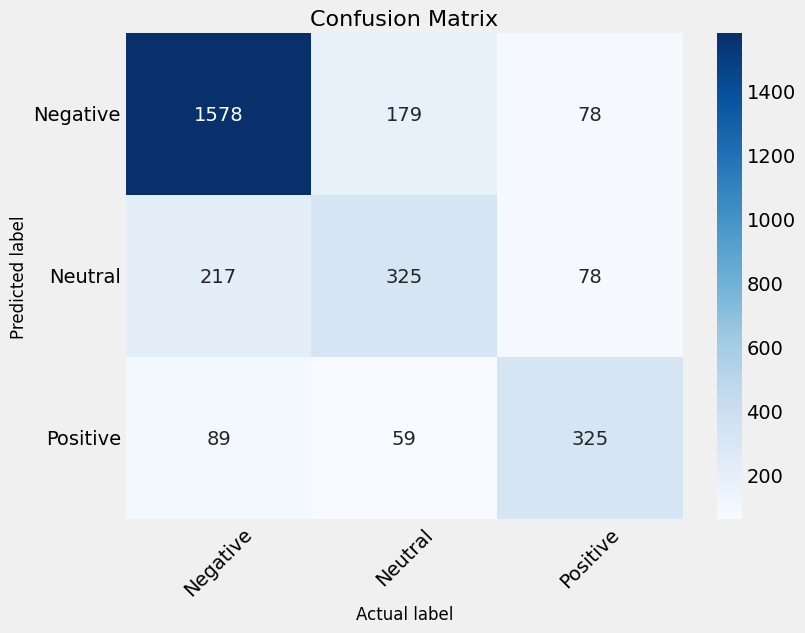

In [60]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test), axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes
                )
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better alignment
    plt.yticks(rotation=0)   # Keep y-axis labels horizontal

plot_confusion_matrix(model, X_tst, y_tst)


# Sentiment Analysis with Random Forest Classifier

In this section, we perform sentiment analysis using a Random Forest Classifier. The goal is to classify airline sentiments based on preprocessed text data.

#### Data Preparation

First, we prepare the data for sentiment analysis:

In [61]:
X = data['final_text']
y = data['airline_sentiment']

## Now Apply TFIDF on cleaned tweets

In [62]:
tfid = TfidfVectorizer()
X_final =  tfid.fit_transform(X)

## Handling Class Imbalance with SMOTE

In [63]:
# Handling imbalanced using SMOTE
smote = SMOTE()
x_sm,y_sm = smote.fit_resample(X_final,y)

## Split Data into train & test

In [64]:
# Split the data into training and testing sets
X_train , X_test , y_train , y_test = train_test_split(x_sm , y_sm , test_size=0.25,random_state=3)

## Training a Random Forest Classifier

In [65]:
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(X_train,y_train)

RandomForestClassifier()

The RandomForestClassifier is now trained on the preprocessed text data for sentiment classification.

## Evaluating the Random Forest Classifier

In [66]:
random_forest_classifier_prediction =  random_forest_classifier.predict(X_test)

In [67]:
accuracy_score(random_forest_classifier_prediction,y_test)

0.8757989540964556

## Training the XGBoost Classifier

In [68]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

## Evaluating the XGBoost Classifier

In [69]:
xgb_prediction =  xgb.predict(X_test)

In [70]:
accuracy_score(xgb_prediction,y_test)

0.8117373619988378

## Training the Gradient Boosting Classifier

In [71]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train,y_train)

GradientBoostingClassifier()

## Accuracy of the Gradient Boosting Classifier Model

In [72]:
gbc_prediction =  gbc.predict(X_test)

In [73]:
accuracy_score(gbc_prediction,y_test)

0.7450610110400929

## Training a Support Vector Machine (SVM) Classifier

In [74]:
svm = SVC()
svm.fit(X_train,y_train)

SVC()

## Evaluating Support Vector Machine (SVM) Classifier

In [75]:
svm_prediction =  svm.predict(X_test)

In [76]:
accuracy_score(svm_prediction,y_test)

0.8583672283556072

## Training a Multinomial Naive Bayes Classifier

In [77]:
nb = MultinomialNB()
nb.fit(X_train,y_train)

MultinomialNB()

## Evaluating Multinomial Naive Bayes Classifier

In [78]:
nb_prediction =  nb.predict(X_test)

In [79]:
accuracy_score(nb_prediction,y_test)

0.8191458454386984

## Training a Decision Tree Classifier

In [80]:
des_tree_classifier = DecisionTreeClassifier()
des_tree_classifier.fit(X_train,y_train)

DecisionTreeClassifier()

## Evaluating the Decision Tree Classifier

In [81]:
des_tree_classifier_prediction=des_tree_classifier.predict(X_test)

In [82]:
accuracy_score(des_tree_classifier_prediction,y_test)

0.8204532248692621

## Random Forest Classifier Evaluation

In [83]:
cr = classification_report(y_test, random_forest_classifier_prediction)

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.88      0.84      0.86      2343
           1       0.84      0.87      0.85      2264
           2       0.91      0.92      0.92      2277

    accuracy                           0.88      6884
   macro avg       0.88      0.88      0.88      6884
weighted avg       0.88      0.88      0.88      6884



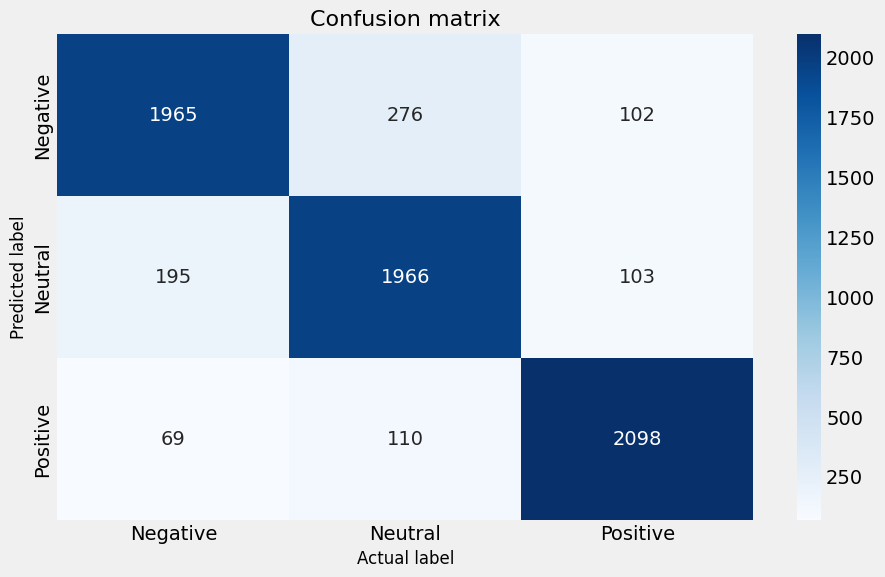

In [84]:
print("Classification Report:\n----------------------\n", cr)

cm = confusion_matrix(y_test,random_forest_classifier_prediction)


# plot confusion matrix
plt.figure(figsize=(10,6))
sentiment_classes = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)
plt.show()